# Harris Corner Detector
The Harris corner detector is a corner detection operator that is commonly used in computer vision algorithms to extract corners and infer features of an image. It was first introduced by Chris Harris and Mike Stephens in 1988 upon the improvement of Moravec's corner detector.[1] Compared to the previous one, Harris' corner detector takes the differential of the corner score into account with reference to direction directly, instead of using shifting patches for every 45 degree angles, and has been proved to be more accurate in distinguishing between edges and corners.[2] Since then, it has been improved and adopted in many algorithms to preprocess images for subsequent applications.

In [141]:
import numpy as np
from scipy import ndimage as nd
import math
from PIL import Image
import matplotlib.pyplot as plt

# Clean functions

In [142]:
# Gradient in x-direction
def Sobelx(image):
    sobelx = np.array([[1,0,-1],
                    [2,0,-2],
                    [1,0,-1]])
    Ix = nd.convolve(image,sobelx)           
    return Ix


# Gradient in y-direction
def Sobely(image):
    sobely = np.array([[ 1, 2, 1],
                    [ 0, 0, 0],
                    [-1,-2,-1]])

    Iy = nd.convolve(image,sobely)
    return Iy


# Convert RGB to grayscale
def rgb2gray(image):
    image = np.array(image)
    r, c, ch = image.shape
    gray = np.zeros([r,c])

    gray = np.mean(image, axis=2)
    return gray


# Reduce image size
def reduceRes(image,factor):
    r,c = image.size
    r = np.int(np.floor(r/factor))
    c = np.int(np.floor(c/factor))
    new = image.resize((r,c))
    return new


# Box filter for smoothing
def boxFilter(image,rc):
    box = np.ones([rc,rc])/rc**2
    image = nd.convolve(gray,box)
    return image


# Pad image with zeros
def pad(image,factor):
    r_img, c_img = image.shape
    pad = np.zeros([r_img,factor])
    image = np.hstack([pad,image,pad])

    r_img, c_img = image.shape
    pad = np.zeros([factor,c_img])
    image = np.vstack([pad,image,pad])

    return image


# Peak finding for nonmax supression
def peaks(image,window):
    factor = int(np.floor(window/2))
    image = pad(image,factor)
    peaks = np.zeros([image.shape[0],image.shape[1]])

    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            window = image[i-1:i+2,j-1:j+2]
            if image[i,j]==np.amax(window):
                peaks[i,j] = image[i,j]


    # remove padding
    peaks = peaks[factor:-factor,factor:-factor]

    return peaks


# Norm CC feature matching
def norm_cross_corr(image,filter):
    r,c = image.shape
    ncc = np.zeros([r,c])
    
    add = np.int((filter.shape[0]-1)/2)
    padded = pad(image,add)

    for i in range(r):
        for j in range(c):
            f = padded[i:i+filter.shape[0],j:j+filter.shape[1]]
            if np.sum(np.sqrt(f**2))==0:
                norm_f = np.zeros([f.shape[0],f.shape[1]])
            else:
                norm_f = f/np.sqrt(np.sum(f**2))
            norm_g = filter/np.sqrt(np.sum(filter**2))

            norm_f = np.reshape(norm_f,[1,filter.size])
            norm_g = np.reshape(norm_g,[filter.size,1])

            ncc[i,j] = np.dot(norm_f,norm_g)
            
    return ncc

# Load Image, Reduce Resolution, RGB to Gray

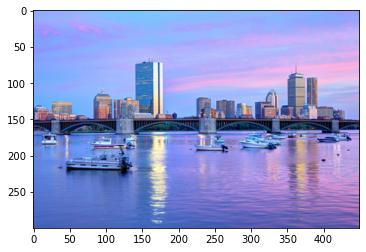

In [143]:
# Load image
file = 'boston_skyline.jpg'
image = Image.open(file)

# Reduce resolution
image = reduceRes(image,2)

# Convert to grayscale
gray = rgb2gray(image)

# Smooth image
gray = boxFilter(gray,3)

plt.imshow(image)

# Find Corners
with a threshold of <200 pixels/corner

In [144]:
def HarrisCorner(image,threshold):

    # Find gradients
    Ix = Sobelx(image)
    Iy = Sobely(image)
    Ixx = Ix**2
    Iyy = Iy**2

    # Compute R values
    detM = Ixx*Iyy
    traceM = Ixx+Iyy
    k = 0.05
    R = detM - k*traceM**2

    # Threshold values
    R[R <= threshold*np.amax(R)] = 0
    
    # Nonmax Supression
    R = peaks(R,3)

    return R


def getRandPatch(corners,patch_size):
    
    # Choose random corner
    idx = np.where(corners>0)
    idx = np.array(idx).T
    rand_corner = np.random.randint(idx.shape[0],size=1)
    
    loc = idx[rand_corner,:]
    loc = np.concatenate(loc)
    r = loc[0]
    c = loc[1]
    print('Patch:',r,c)

    left = np.int( (patch_size-1)/2 )
    right = np.int( (patch_size-1)/2 + 1 )
    patch = np.around(corners[r-left:r+right,c-left:c+right])
    return patch

pixels/feature: 45000.0
pixels/feature: 7105.0
pixels/feature: 2288.0
pixels/feature: 1071.0
pixels/feature: 572.0
pixels/feature: 384.0
pixels/feature: 255.0
pixels/feature: 189.0
pixels/feature: 150.0
pixels/feature: 126.0
pixels/feature: 107.0
pixels/feature: 94.0
Threshold: 0.0002197265625
Features: 1431


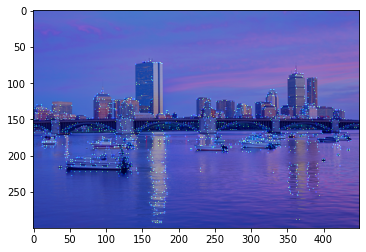

In [150]:
# Reduce threshold until 1% of pixels are corners
ratio = 1000
threshold = 0.9
while ratio >= 100:
    threshold = 0.5*threshold

    corners = HarrisCorner(gray,threshold)
    # Number of corners
    idx = np.where(corners>0)
    idx = np.array(idx).T
    ratio = gray.size/idx.shape[0]
    print('pixels/feature:', np.round(ratio))

print('Threshold:',threshold)
print('Features:',idx.shape[0])
plt.imshow(image)
plt.imshow(corners>0, cmap = "jet", alpha = 0.4)

# Find corners that have neighbors in filter window
Becaues the NCC of both these arrays are equal:\
0,0,0 -> 0,0,0\
0,1,0 -> 0,5,0\
0,0,0 -> 0,0,0\
Isolated corners are matches on both images

1431.0


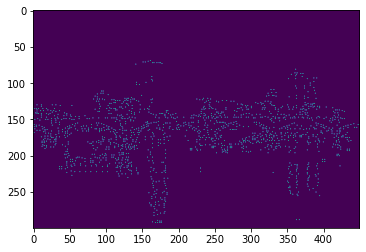

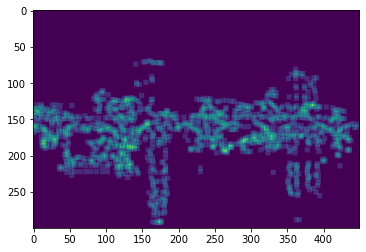

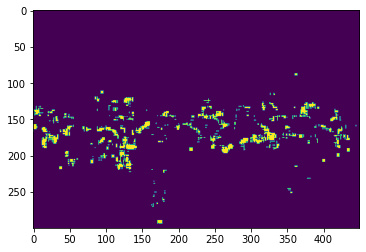

361.0


In [146]:
# Remove isolated corners in a window

good_corners = np.copy(corners)
good_corners[good_corners>0] = 1
good_corners[good_corners<0] = 0
print(np.sum(good_corners))

plt.imshow(good_corners)
plt.show()

width = 7
filter = np.ones([width,width])
neighbors = nd.convolve(good_corners,filter)
plt.imshow(neighbors)
plt.show()

threshold = 4
neighbors[neighbors<threshold] = 0
neighbors[neighbors>=threshold] = 1
plt.imshow(neighbors)
plt.show()

print(np.sum(neighbors*good_corners))

# Match corners with Normalized Cross Correlation
Throwout matches with more than one best match

Patch: 257 168
Too many matches: 232
Patch: 188 391
Too many matches: 232
Patch: 160 259
It's a match! -  [[160 259]]
Patch: 199 100
It's a match! -  [[199 100]]
Patch: 177 124
It's a match! -  [[177 124]]
Patch: 174 11
Too many matches: 232
Patch: 222 230
Too many matches: 232
Patch: 193 264
It's a match! -  [[193 264]]
Patch: 163 321
It's a match! -  [[163 321]]


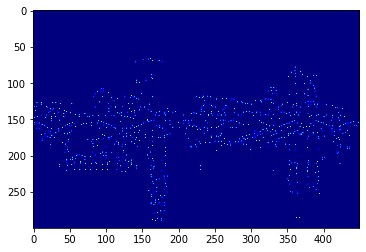

In [147]:
i = 0

while i<5:
    # Get a random patch
    patch = getRandPatch(corners,width)

    # Try to match the corner patch
    fit = norm_cross_corr(corners,patch)

    best = np.where(fit==np.amax(fit))
    best = np.array(best).T
    matches = best.shape[0]
    
    if matches == 1:
        print("It's a match! - ",best)
        i+=1
    else:
        print('Too many matches:',best.shape[0])
        # retry

fit[fit <= 0.5] = 0
plt.imshow(fit,cmap ='jet')

# Split images for testing

In [148]:
# Split image into top left and bottom right with overlap
r,c = gray.shape
split = 5
topleft = gray[0:np.int(np.floor(r-r/split)), 0:np.int(np.floor(c-c/split))]
botright = gray[np.int(np.floor(r-(split-1)*r/split)):-1, np.int(np.floor(c-(split-1)*c/split)):-1]

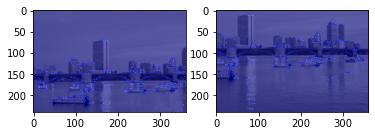

In [149]:
threshold = 0.003

plt.subplot(1,2,1)
corners = HarrisCorner(topleft,threshold)
plt.imshow(topleft, cmap = "gray")
plt.imshow(corners>0, cmap = "jet", alpha = 0.6)


plt.subplot(1,2,2)
corners = HarrisCorner(botright,threshold)
plt.imshow(botright, cmap = "gray")
plt.imshow(corners>0, cmap = "jet", alpha = 0.6)